In [101]:
import librosa
import librosa.display
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import torch.nn as nn
import matplotlib.pyplot as plt
import string
import io
import os
import unicodedata
import string
import glob

import torch
import random

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Model : LSTM + Linear for classification
### Data: lenght 1 audio CAPTCHAs from the botdetect website 
### input features: Mel-Frequency Ceptrum Coefficients (MFCC)
### output classes: 26 + 10 ( 26 Captical letters + 10 digits)

### Data Preparation

In [102]:
input_size = 13

#num_layers 
learning_rate = 0.001
# class numbers (26 Captical letters + 10 digits)

num_classes = 36  #26 + 10

batch_size = 64
# extract features from audio file
def extract_mfcc(audio_path):
  x, sr = librosa.load(audio_path)
  mfccs = librosa.feature.mfcc(x, sr=sr,n_mfcc=input_size)
  return mfccs.T

In [103]:
t = string.ascii_uppercase+string.digits
lookup = dict()
for x, y in enumerate([*t]):
  lookup[y] = x

In [104]:
class CAPTCHADataset(Dataset):
  def __init__(self):
    super().__init__()
    file_path = '/content/drive/MyDrive/Deakin_2022_T3/SIT782_CapstoneB/CAPTCHAs/botdetect'
    audio_dataset = []
    for x in glob.glob(os.path.join(file_path,'*.wav')):
      mfcc = extract_mfcc(x)
      audio_dataset.append(torch.Tensor(mfcc))
    
    self.x_data = torch.nn.utils.rnn.pad_sequence(audio_dataset,batch_first=True,padding_value=0)
    with open(os.path.join(file_path, 'labels.txt')) as f:
      self.y_data = [lookup[x.strip()] for x in f.readlines()]
    self.min_len = min(len(self.x_data),len(self.y_data))
    
  def __getitem__(self, index):
      sample = self.x_data[index], self.y_data[index]
      return sample
    
  def __len__(self):
      return self.min_len


In [105]:
dataset = CAPTCHADataset()

In [106]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 200

num_iterations = math.ceil(len(dataset)/batch_size)
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size,num_layers, num_classes):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes )

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    out, _ = self.lstm(x,(h0,c0))
    out = out[:, -1, :]

    out = self.fc(out)
    return out


### Train test split

In [107]:
dataset_train, dataset_validation, dataset_test = torch.utils.data.random_split(dataset, [0.8,0.1,0.1],generator=torch.Generator().manual_seed(42))

In [108]:
data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True,num_workers=2)
data_loader_validation = DataLoader(dataset=dataset_validation, batch_size=batch_size, shuffle=False,num_workers=2)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False,num_workers=2)

adjust the learning rate for better performance with ExponentialLR

In [112]:

def train_LSTM_model(model):
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
  model_loss = []
  for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(data_loader_train):
    
      data = data.to(device=device).squeeze(1)
      targets = targets.to(device=device)
      scores = model(data)
      loss = criterion(scores, targets)
  
      if (batch_idx) % 20 == 0:
        print(f'epoch {epoch+1}/{num_epochs}, step {batch_idx+1}/{num_iterations} loss {loss}')
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    model_loss.append(loss.item()) 
    scheduler.step()
  plt.title('Training loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.plot(model_loss)
  return model


In [113]:
def model_accuracy(model,data_loader):
  with torch.no_grad():
    correct = 0
    samples = 0
    for data, targets in data_loader:
      data = data.to(device=device).squeeze(1)
      targets = targets.to(device=device)
      samples += targets.size(0)
      outputs = model(data)
      _, predicted = torch.max(outputs.data,1)
      correct += (predicted == targets).sum().item()
  accuracy = 100 * correct/samples
  print(f'model accuracy is {accuracy:.3f}%')

### Hyperparameter tunning

epoch 1/200, step 1/2 loss 3.577308177947998
epoch 2/200, step 1/2 loss 3.539684295654297
epoch 3/200, step 1/2 loss 3.500013828277588
epoch 4/200, step 1/2 loss 3.4427361488342285
epoch 5/200, step 1/2 loss 3.363452196121216
epoch 6/200, step 1/2 loss 3.1512291431427
epoch 7/200, step 1/2 loss 3.115847110748291
epoch 8/200, step 1/2 loss 2.967494010925293
epoch 9/200, step 1/2 loss 3.042778491973877
epoch 10/200, step 1/2 loss 2.980602741241455
epoch 11/200, step 1/2 loss 3.026465654373169
epoch 12/200, step 1/2 loss 2.9736826419830322
epoch 13/200, step 1/2 loss 3.0221056938171387
epoch 14/200, step 1/2 loss 3.0327415466308594
epoch 15/200, step 1/2 loss 3.0409131050109863
epoch 16/200, step 1/2 loss 2.972987174987793
epoch 17/200, step 1/2 loss 3.018983840942383
epoch 18/200, step 1/2 loss 2.9347736835479736
epoch 19/200, step 1/2 loss 2.9724040031433105
epoch 20/200, step 1/2 loss 2.8850953578948975
epoch 21/200, step 1/2 loss 2.964601755142212
epoch 22/200, step 1/2 loss 2.9592530

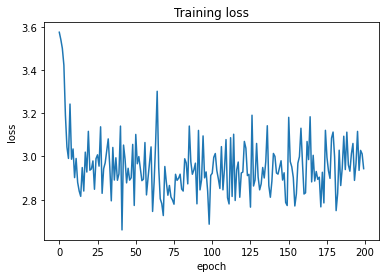

In [114]:
hidden_size = 256
num_layers=2

model_1 = LSTM(input_size, hidden_size, num_layers, num_classes)
model_1 = train_LSTM_model(model_1)
model_accuracy(model_1,data_loader_validation)

epoch 1/200, step 1/2 loss 3.5849621295928955
epoch 2/200, step 1/2 loss 3.5648155212402344
epoch 3/200, step 1/2 loss 3.5420634746551514
epoch 4/200, step 1/2 loss 3.5186405181884766
epoch 5/200, step 1/2 loss 3.488999843597412
epoch 6/200, step 1/2 loss 3.418623447418213
epoch 7/200, step 1/2 loss 3.315079927444458
epoch 8/200, step 1/2 loss 3.1851279735565186
epoch 9/200, step 1/2 loss 3.1733179092407227
epoch 10/200, step 1/2 loss 3.183204412460327
epoch 11/200, step 1/2 loss 3.1098990440368652
epoch 12/200, step 1/2 loss 3.090230941772461
epoch 13/200, step 1/2 loss 3.0506832599639893
epoch 14/200, step 1/2 loss 3.0860726833343506
epoch 15/200, step 1/2 loss 3.0752668380737305
epoch 16/200, step 1/2 loss 3.1211531162261963
epoch 17/200, step 1/2 loss 3.1483545303344727
epoch 18/200, step 1/2 loss 2.990130662918091
epoch 19/200, step 1/2 loss 2.9836108684539795
epoch 20/200, step 1/2 loss 3.0501723289489746
epoch 21/200, step 1/2 loss 3.137721538543701
epoch 22/200, step 1/2 loss 3

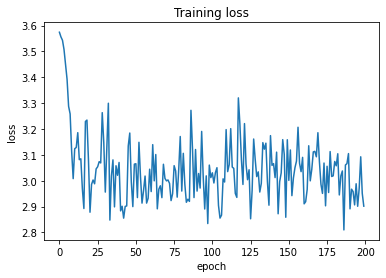

In [115]:
hidden_size = 128
num_layers=4

model_2 = LSTM(input_size, hidden_size, num_layers, num_classes)
model_2 = train_LSTM_model(model_2)
model_accuracy(model_2,data_loader_validation)

### Testing

In [116]:
# model_2 has higher accuracy than model_1,so I choose model_2
model_accuracy(model_2,data_loader_test)

model accuracy is 18.182%
